<a href="https://colab.research.google.com/github/hchaparov/Dynamic_Pricing_MARL/blob/main/Final_SA_Pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install ffmpeg
!pip install swig

In [3]:
from google.colab import drive
drive.mount('/content/drive')

from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from IPython.display import HTML
from base64 import b64encode
import gymnasium as gym
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
import sys
import inspect
import numpy as np

import torch as th
import torch.nn as nn
th.set_printoptions(profile="full")

from tqdm.auto import tqdm
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.monitor import Monitor, load_results
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import matplotlib.pyplot as plt

from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

Mounted at /content/drive


In [4]:
ENV_ID = "PongNoFrameskip-v4"
n_training_envs = 8


LOG_DIR_PPO = "/content/drive/My Drive/SA_PongNoFrameskip_all_test/PPO"
os.makedirs(LOG_DIR_PPO, exist_ok=True)

LOG_DIR_PPO_EV = "/content/drive/My Drive/SA_PongNoFrameskip_all_test/PPO_eval"
os.makedirs(LOG_DIR_PPO_EV, exist_ok=True)

LOG_DIR_A2C = "/content/drive/My Drive/SA_PongNoFrameskip_all_test/A2C"
os.makedirs(LOG_DIR_A2C, exist_ok=True)

LOG_DIR_A2C_EV = "/content/drive/My Drive/SA_PongNoFrameskip_all_test/A2C_eval"
os.makedirs(LOG_DIR_A2C_EV, exist_ok=True)

LOG_DIR_DQN = "/content/drive/My Drive/SA_PongNoFrameskip_all_test/DQN"
os.makedirs(LOG_DIR_DQN, exist_ok=True)

LOG_DIR_DQN_EV = "/content/drive/My Drive/SA_PongNoFrameskip_all_test/DQN_eval"
os.makedirs(LOG_DIR_DQN_EV, exist_ok=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Initialize a vectorized training environment with default parameters
train_env_ppo = make_atari_env(ENV_ID, n_envs=n_training_envs, monitor_dir=LOG_DIR_PPO, seed=0)

eval_env_ppo = make_atari_env(ENV_ID, n_envs=n_training_envs, monitor_dir=LOG_DIR_PPO_EV, seed=0)

train_env_a2c = make_atari_env(ENV_ID, n_envs=n_training_envs, monitor_dir=LOG_DIR_A2C, seed=0)

eval_env_a2c = make_atari_env(ENV_ID, n_envs=n_training_envs, monitor_dir=LOG_DIR_A2C_EV, seed=0)

train_env_dqn = make_atari_env(ENV_ID, n_envs=n_training_envs, monitor_dir=LOG_DIR_DQN, seed=0)

eval_env_dqn = make_atari_env(ENV_ID, n_envs=n_training_envs, monitor_dir=LOG_DIR_DQN_EV, seed=0)

In [6]:
def eval_callback(eval_env, log_dir_ev):
  EVAL_FREQ = 8192 # The policy is updated every 8196 timesteps
  EVAL_EPISODES = 16 # How many episodes the agent should be tested for evaluation

  eval_callback_z = EvalCallback(
                    eval_env = eval_env,
                    n_eval_episodes = EVAL_EPISODES,
                    best_model_save_path = log_dir_ev,
                    log_path = log_dir_ev,
                    eval_freq = EVAL_FREQ,
                    deterministic = True,
                    render = False
                )
  return eval_callback_z

In [7]:
MODEL_PATH_PPO = "/content/drive/My Drive/SA_PongNoFrameskip_all_test/PPO/model_10mil"
MODEL_PATH_A2C = "/content/drive/My Drive/SA_PongNoFrameskip_all_test/A2C/model_10mil"
MODEL_PATH_DQN = "/content/drive/My Drive/SA_PongNoFrameskip_all_test/DQN/model_10mil"

TOTAL_TIMESTEPS = 10000000


model_ppo = PPO(policy = "CnnPolicy",
            env = train_env_ppo,
            batch_size = 256,
            clip_range = 0.1,
            ent_coef = 0.01,
            gae_lambda = 0.9,
            gamma = 0.99,
            learning_rate = 0.00025,
            max_grad_norm = 0.5,
            n_epochs = 4,
            n_steps = 128,
            vf_coef = 0.5,
            verbose=1
            )


eval_callback_ppo = eval_callback(eval_env=eval_env_ppo, log_dir_ev=LOG_DIR_PPO_EV)



model_a2c = A2C(policy = "CnnPolicy",
            env = train_env_a2c,
            ent_coef = 0.01,
            gamma = 0.99,
            learning_rate = 0.00025,
            max_grad_norm = 0.5,
            n_steps = 128,
            vf_coef = 0.25,
            verbose = 1
            )

eval_callback_a2c = eval_callback(eval_env=eval_env_a2c, log_dir_ev=LOG_DIR_A2C_EV)



model_dqn = DQN(policy = 'CnnPolicy',
            env=train_env_dqn,
            learning_rate=0.0001,  # exp_config['policy']['learn']['learning_rate']
            buffer_size=100000,    # exp_config['policy']['other']['replay_buffer']['replay_buffer_size']
            learning_starts=1000,
            batch_size=32,         # exp_config['policy']['learn']['batch_size']
            tau=1.0,               # Update the target network
            gamma=0.99,            # exp_config['policy']['discount_factor']
            train_freq=(4, 'step'),
            gradient_steps=1,
            target_update_interval=500,  # exp_config['policy']['learn']['target_update_freq']
            exploration_initial_eps=1.0, # exp_config['policy']['other']['eps']['start']
            exploration_final_eps=0.05,  # exp_config['policy']['other']['eps']['end']
            exploration_fraction=0.1,
            verbose=1,
            )

eval_callback_dqn = eval_callback(eval_env=eval_env_dqn, log_dir_ev=LOG_DIR_DQN_EV)

Using cuda device
Wrapping the env in a VecTransposeImage.
Using cuda device
Wrapping the env in a VecTransposeImage.
Using cuda device
Wrapping the env in a VecTransposeImage.


In [8]:
agent_a2c = model_a2c.learn(total_timesteps = TOTAL_TIMESTEPS, callback =  eval_callback_a2c)
agent_a2c.save(MODEL_PATH_A2C)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7f46bc9ea170> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f46e6bf9bd0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=65536, episode_reward=-21.00 +/- 0.00
Episode length: 3056.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 3.06e+03 |
|    mean_reward        | -21      |
| time/                 |          |
|    total_timesteps    | 65536    |
| train/                |          |
|    entropy_loss       | -1.76    |
|    explained_variance | 0.00337  |
|    learning_rate      | 0.00025  |
|    n_updates          | 63       |
|    policy_loss        | -0.201   |
|    value_loss         | 0.251    |
------------------------------------
New best mean reward!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 3.64e+03 |
|    ep_rew_mean        | -20.3    |
| time/                 |          |
|    fps                | 651      |
|    iterations         | 100      |
|    time_elapsed       | 157      |
|    total_timesteps    | 102400   |
| train/                |          |


    index     r     l          t
0       0 -21.0  3296  21.254553
1       0 -21.0  3300  21.286794
2       0 -20.0  3547  21.984628
3       0 -20.0  3607  22.178442
4       0 -21.0  3611  22.324825
5       0 -21.0  3658  22.458313
6       0 -20.0  4024  23.326391
7       0 -20.0  4242  23.987756
8       1 -21.0  3168  29.663404
9       1 -20.0  3591  30.954260
10      1 -20.0  3367  31.033541
11      1 -20.0  3348  31.183288
12      1 -21.0  3540  31.645898
13      1 -21.0  3286  32.089650
14      1 -21.0  3648  33.751044
15      1 -19.0  4238  33.793221
16      2 -21.0  3296  39.860815
17      2 -21.0  3286  39.958400
18      2 -20.0  4040  40.598095
19      2 -20.0  3783  41.101307
20      2 -20.0  3542  41.540833
21      2 -21.0  3876  42.042778
22      2 -21.0  3296  42.457860
23      2 -18.0  4877  46.746575
24      3 -21.0  3244  49.334467
25      3 -21.0  3544  49.420109
26      3 -20.0  3595  49.695423
27      3 -20.0  3350  50.154279
28      3 -21.0  3131  50.912544
29      3 

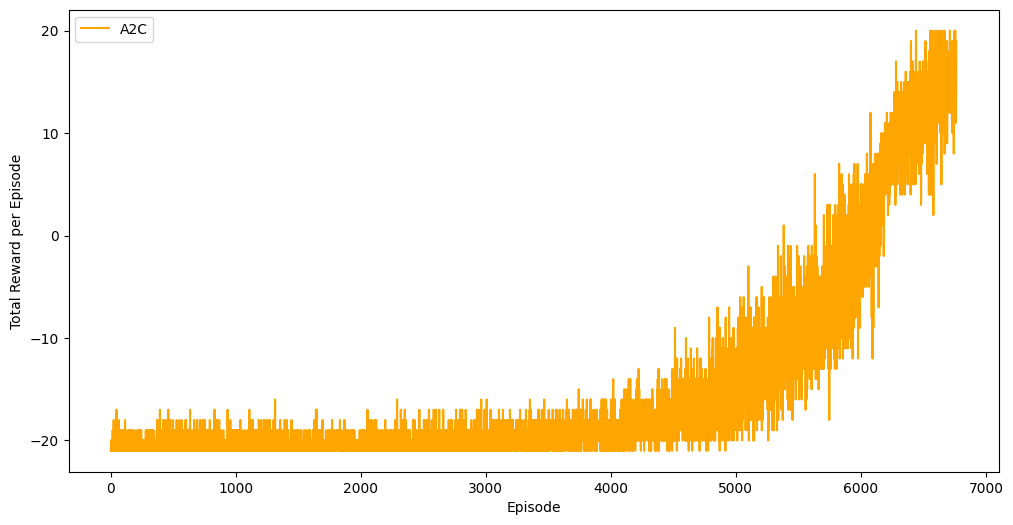

In [9]:
# Load the results from the log directory
results_a2c = load_results(LOG_DIR_A2C)


# Display the first 50 rows of the DataFrame

print(results_a2c.head(50))



# Plot rewards over episode index
plt.figure(figsize=(12, 6))
plt.plot(results_a2c.index, results_a2c['r'], label='A2C', color = 'orange')
plt.xlabel('Episode')
plt.ylabel('Total Reward per Episode')
plt.legend()
plt.show()

In [10]:
video_folder = "logs/videos/"
video_length = 1000# Record the video

env = VecVideoRecorder(train_env_a2c, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"trained-agent-{ENV_ID}")

# Reset the environment
obs = env.reset()

# Run the environment for the specified number of steps using the trained model
for _ in range(video_length + 1):
    action, _ = agent_a2c.predict(obs)  # Predict the action using the trained model
    obs, _, _, _ = env.step(action)  # Take the action in the environment

# Close the VecVideoRecorder and save the video
env.close()

# Function to display the video
def show_video(video_path):
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f'<video width="480" height="320" controls><source src="{data_url}" type="video/mp4"></video>')

# Display the video
show_video(video_folder + f"trained-agent-{ENV_ID}-step-0-to-step-{video_length}.mp4")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Saving video to /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4
Moviepy - Building video /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4


In [ ]:
agent_dqn = model_dqn.learn(total_timesteps = TOTAL_TIMESTEPS, callback =  eval_callback_dqn)
agent_dqn.save(MODEL_PATH_DQN)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7f46bc9ea890> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f46e6bfa7d0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00858  |
|    n_updates        | 203903   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.64e+03 |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4184     |
|    fps              | 422      |
|    time_elapsed     | 15459    |
|    total_timesteps  | 6535264  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00477  |
|    n_updates        | 204195   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.65e+03 |
|    ep_rew_mean      | -12.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4188     |
|   

    index     r     l             t
0       0 -21.0  3339  19849.590314
1       0 -21.0  3368  19849.708496
2       0 -20.0  3460  19849.897865
3       0 -20.0  3685  19850.455690
4       0 -20.0  3734  19850.553232
5       0 -21.0  3764  19850.625850
6       0 -21.0  3888  19850.894533
7       0 -19.0  4148  19851.507693
8       1 -21.0  3168  19857.006629
9       1 -21.0  3056  19857.405226
10      1 -21.0  3168  19857.747735
11      1 -21.0  3780  19858.152419
12      1 -21.0  3760  19858.208716
13      1 -21.0  3131  19858.581872
14      1 -20.0  3940  19859.414097
15      1 -21.0  3943  19859.810225
16      2 -20.0  3623  19865.622095
17      2 -20.0  3847  19865.774446
18      2 -20.0  3481  19866.092720
19      2 -21.0  3280  19866.842961
20      2 -21.0  3168  19866.970922
21      2 -19.0  4344  19867.676549
22      2 -19.0  4353  19868.098635
23      2 -18.0  4849  19869.627858
24      3 -21.0  3168  19874.165146
25      3 -19.0  3752  19874.329458
26      3 -20.0  3609  19874

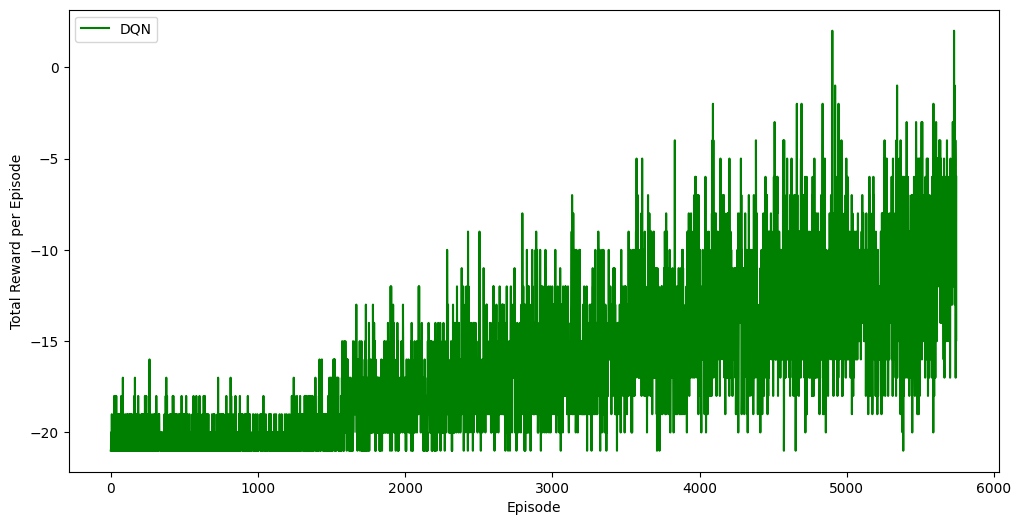

In [20]:
# Load the results from the log directory
results_dqn = load_results(LOG_DIR_DQN)

# Display the first 50 rows of the DataFrame

print(results_dqn.head(50))


# Plot rewards over episode index
plt.figure(figsize=(12, 6))
plt.plot(results_dqn.index, results_dqn['r'], label='DQN',color = 'green')
plt.xlabel('Episode')
plt.ylabel('Total Reward per Episode')
plt.legend()
plt.show()

In [21]:
video_folder = "logs/videos/"
video_length = 1000# Record the video

env = VecVideoRecorder(train_env_dqn, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"trained-agent-{ENV_ID}")

# Reset the environment
obs = env.reset()

# Run the environment for the specified number of steps using the trained model
for _ in range(video_length + 1):
    action, _ = agent_dqn.predict(obs)  # Predict the action using the trained model
    obs, _, _, _ = env.step(action)  # Take the action in the environment

# Close the VecVideoRecorder and save the video
env.close()

# Function to display the video
def show_video(video_path):
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f'<video width="480" height="320" controls><source src="{data_url}" type="video/mp4"></video>')

# Display the video
show_video(video_folder + f"trained-agent-{ENV_ID}-step-0-to-step-{video_length}.mp4")

ValueError: I/O operation on closed file.

In [14]:
agent_ppo = model_ppo.learn(total_timesteps = TOTAL_TIMESTEPS, callback =  eval_callback_ppo)
agent_ppo.save(MODEL_PATH_PPO)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7f46e695c280> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f46e6bfa4a0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Streaming output truncated to the last 5000 lines.
|    entropy_loss         | -0.741      |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0233     |
|    n_updates            | 38116       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 0.00256     |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 6.58e+03    |
|    ep_rew_mean          | 20.9        |
| time/                   |             |
|    fps                  | 544         |
|    iterations           | 9531        |
|    time_elapsed         | 17937       |
|    total_timesteps      | 9759744     |
| train/                  |             |
|    approx_kl            | 0.008733495 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.1         |
|    entropy_loss         | -0.707      |
|    explained_variance  

    index     r     l             t
0       0 -21.0  3168  42170.635483
1       0 -20.0  3370  42171.172319
2       0 -21.0  3416  42171.372869
3       0 -20.0  3481  42171.497216
4       0 -20.0  3485  42171.515601
5       0 -21.0  3489  42171.548752
6       0 -20.0  3588  42171.845340
7       0 -19.0  3985  42173.036754
8       1 -21.0  3493  42181.794089
9       1 -19.0  4014  42182.283345
10      1 -20.0  3607  42182.355926
11      1 -20.0  3840  42182.834577
12      1 -20.0  3902  42182.917225
13      1 -20.0  3972  42183.255213
14      1 -20.0  4210  42183.511898
15      1 -20.0  3719  42183.888161
16      2 -21.0  3243  42191.294457
17      2 -21.0  3131  42191.677953
18      2 -20.0  3367  42192.260199
19      2 -20.0  3374  42192.664208
20      2 -21.0  3280  42193.185227
21      2 -20.0  3839  42193.934210
22      2 -20.0  3647  42194.574170
23      2 -20.0  3955  42194.791344
24      3 -19.0  3667  42201.524900
25      3 -20.0  3481  42202.074964
26      3 -21.0  3355  42202

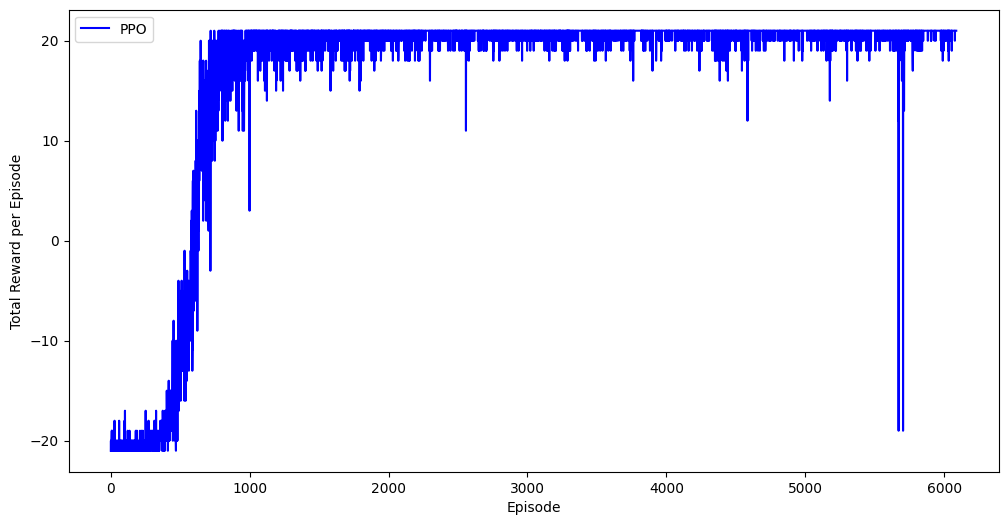

In [15]:
# Load the results from the log directory
results_ppo = load_results(LOG_DIR_PPO)

# Display the first 50 rows of the DataFrame

print(results_ppo.head(50))


# Plot rewards over episode index
plt.figure(figsize=(12, 6))
plt.plot(results_ppo.index, results_ppo['r'], label='PPO', color = 'blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward per Episode')
plt.legend()
plt.show()

In [16]:
video_folder = "logs/videos/"
video_length = 1000# Record the video

env = VecVideoRecorder(train_env_ppo, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"trained-agent-{ENV_ID}")

# Reset the environment
obs = env.reset()

# Run the environment for the specified number of steps using the trained model
for _ in range(video_length + 1):
    action, _ = agent_ppo.predict(obs)  # Predict the action using the trained model
    obs, _, _, _ = env.step(action)  # Take the action in the environment

# Close the VecVideoRecorder and save the video
env.close()

# Function to display the video
def show_video(video_path):
    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f'<video width="480" height="320" controls><source src="{data_url}" type="video/mp4"></video>')

# Display the video
show_video(video_folder + f"trained-agent-{ENV_ID}-step-0-to-step-{video_length}.mp4")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Saving video to /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4
Moviepy - Building video /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/videos/trained-agent-PongNoFrameskip-v4-step-0-to-step-1000.mp4


In [ ]:
agent_ppo = PPO.load(MODEL_PATH_PPO, env = train_env_ppo)
agent_a2c = A2C.load(MODEL_PATH_A2C, env = train_env_a2c)
agent_dqn = DQN.load(MODEL_PATH_DQN, env = train_env_dqn)

from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from the log directory
results_ppo = load_results(LOG_DIR_PPO)
results_a2c = load_results(LOG_DIR_A2C)
results_dqn = load_results(LOG_DIR_DQN)

# Display the first 50 rows of the DataFrame

print(results_ppo.head(50))
print(results_a2c.head(50))
print(results_dqn.head(50))


# Plot rewards over episode index
plt.figure(figsize=(12, 6))
plt.plot(results_ppo.index, results_ppo['r'], label='PPO')
plt.plot(results_a2c.index, results_a2c['r'], label='A2C')
plt.plot(results_dqn.index, results_dqn['r'], label='DQN')
plt.xlabel('Episode')
plt.ylabel('Total Reward per Episode')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


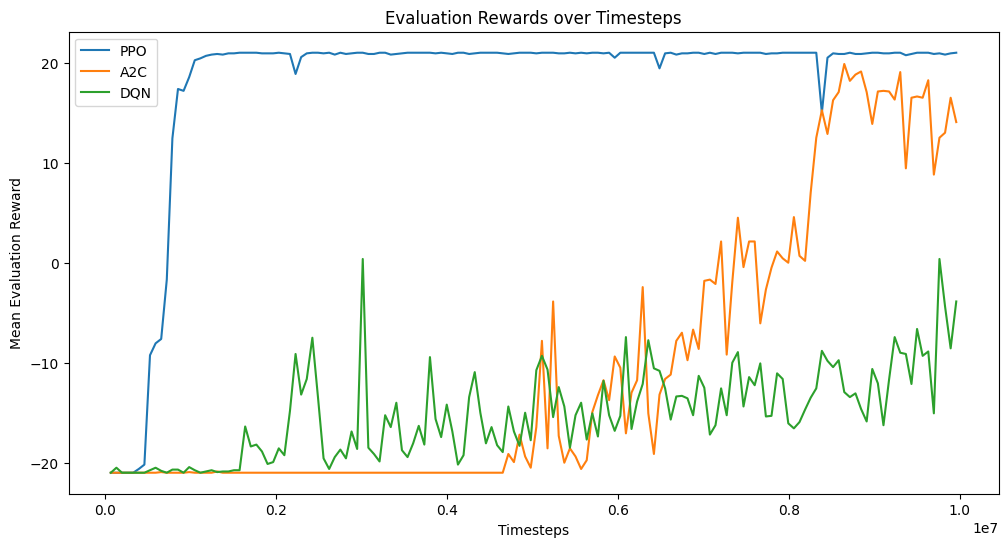

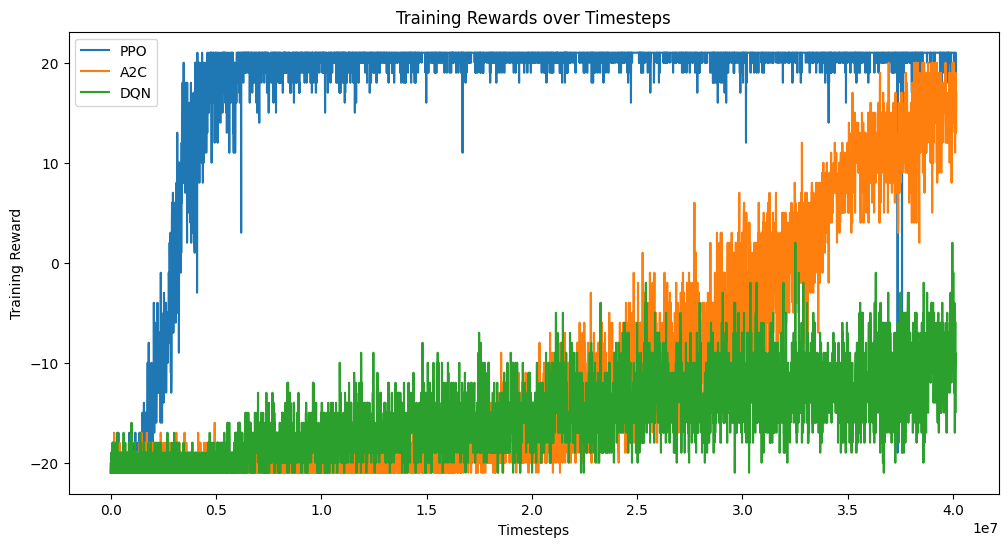

In [18]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Load the evaluation results
def load_evaluation_results(log_dir):
    results = []
    for file_name in os.listdir(log_dir):
        if 'evaluations.npz' in file_name:
            data = np.load(os.path.join(log_dir, file_name))
            results.append((data['timesteps'], data['results']))
    return results

eval_results_ppo = load_evaluation_results(LOG_DIR_PPO_EV)
eval_results_a2c = load_evaluation_results(LOG_DIR_A2C_EV)
eval_results_dqn = load_evaluation_results(LOG_DIR_DQN_EV)

def plot_evaluation_results(eval_results, label):
    timesteps, rewards = zip(*eval_results)
    timesteps = np.concatenate(timesteps)
    rewards = np.concatenate(rewards)
    mean_rewards = np.mean(rewards, axis=1)
    plt.plot(timesteps, mean_rewards, label=label)

plt.figure(figsize=(12, 6))
plot_evaluation_results(eval_results_ppo, 'PPO')
plot_evaluation_results(eval_results_a2c, 'A2C')
plot_evaluation_results(eval_results_dqn, 'DQN')
plt.xlabel('Timesteps')
plt.ylabel('Mean Evaluation Reward')
plt.legend()
plt.title('Evaluation Rewards over Timesteps')
plt.show()

# Load the training results
def load_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    return timesteps, rewards

train_timesteps_ppo, train_rewards_ppo = load_training_results(LOG_DIR_PPO)
train_timesteps_a2c, train_rewards_a2c = load_training_results(LOG_DIR_A2C)
train_timesteps_dqn, train_rewards_dqn = load_training_results(LOG_DIR_DQN)

plt.figure(figsize=(12, 6))
plt.plot(train_timesteps_ppo, train_rewards_ppo, label='PPO')
plt.plot(train_timesteps_a2c, train_rewards_a2c, label='A2C')
plt.plot(train_timesteps_dqn, train_rewards_dqn, label='DQN')
plt.xlabel('Timesteps')
plt.ylabel('Training Reward')
plt.legend()
plt.title('Training Rewards over Timesteps')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


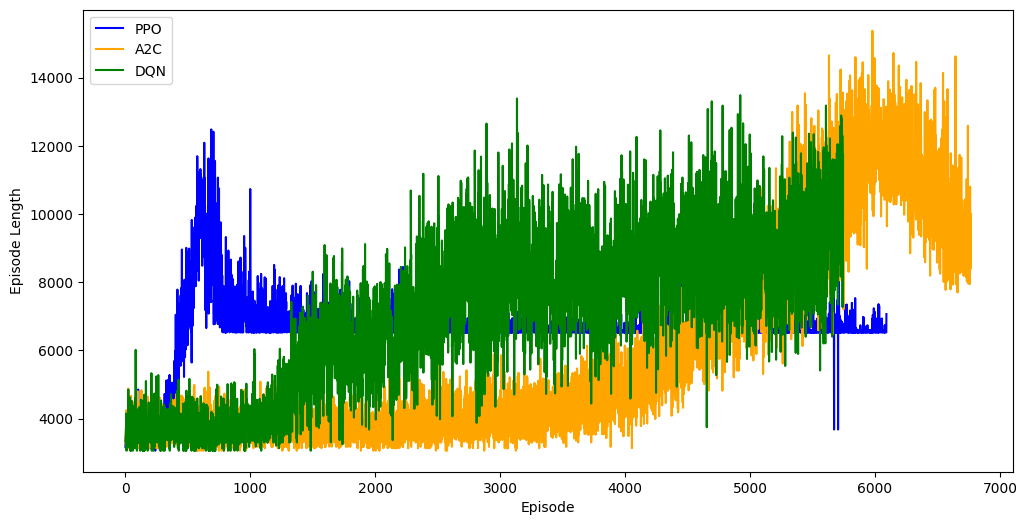

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


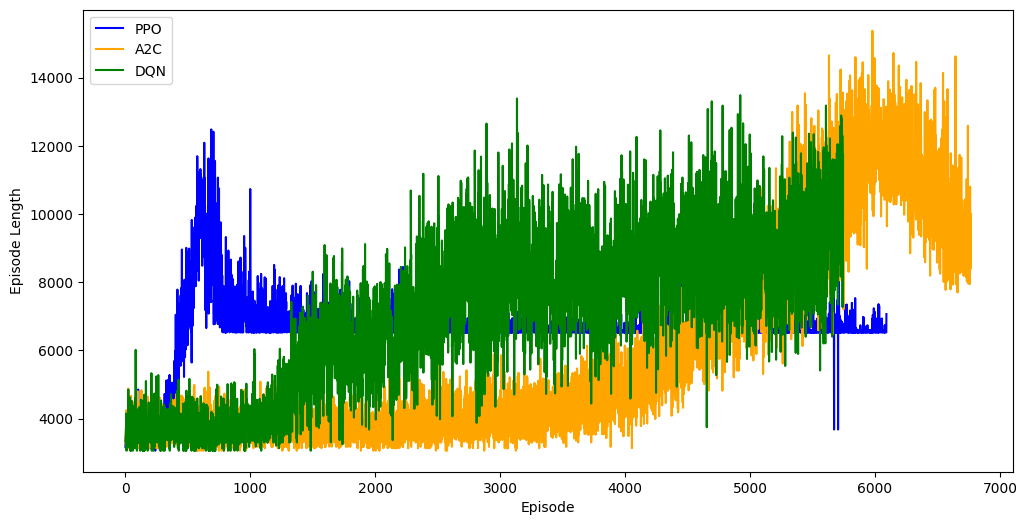

In [19]:
# Function to load episode lengths from the log directory
def load_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    return episode_lengths

# Load episode lengths for PPO, A2C, and DQN
episode_lengths_ppo = load_episode_lengths(LOG_DIR_PPO)
episode_lengths_a2c = load_episode_lengths(LOG_DIR_A2C)
episode_lengths_dqn = load_episode_lengths(LOG_DIR_DQN)

# Plot episode lengths over episode index
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths_ppo, label='PPO', color ='blue')
plt.plot(episode_lengths_a2c, label='A2C', color ='orange')
plt.plot(episode_lengths_dqn, label='DQN', color = 'green')
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.legend()
plt.title('')
plt.show()